# Data Plotting

This notebook is intended to be used on logs created by RomRaider.

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from pathlib import Path
from pprint import pprint
from IPython.display import display, Markdown
from scipy import stats
from scipy.stats import gaussian_kde

sns.set_palette('deep')
sns.set_context('poster')

pd.set_option('display.max_columns', None)

In [58]:
LOG_BASE_DIR = Path('logs/RomRaiders_Logs')

import subprocess
res = subprocess.check_output(f'tree --du -h {LOG_BASE_DIR}', shell=True).decode('utf8')
print(res)

[8.1M]  logs/RomRaiders_Logs
├── [990K]  2022-05-21
│   ├── [627K]  romraiderlog_20220521_183531.csv
│   ├── [152K]  romraiderlog_20220521_192542.csv
│   ├── [ 21K]  romraiderlog_20220521_193149.csv
│   └── [186K]  romraiderlog_20220521_195036.csv
├── [4.7M]  2022-05-26
│   ├── [1.7M]  log_summary.jpg
│   └── [2.9M]  romraiderlog_20220526_102629.csv
├── [118K]  romraiderlog_cold_e10_20220501_182124.csv
├── [110K]  romraiderlog_cold_e10_2_20220501_140718.csv
├── [713K]  romraiderlog_cold_e85_20220520_085008.csv
├── [262K]  romraiderlog_warm_e10_20220510_230224.csv
├── [368K]  romraiderlog_warm_e85_20220519_201207.csv
└── [959K]  romraiderlog_warm_e85_2_20220519_215514.csv

 8.1M used in 2 directories, 12 files



In [63]:
def plot_log(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(34,14))

    # Plot Engine Load versus Fuel Injector Pulse Width
    x = df['* Engine Load (mg/stroke)']
    y = df['* Fuel Injector Pulse Width (ms)']
    
    for ax in (ax1, ax2):
        ax.set_xlabel('Engine Load')
        ax.set_ylabel('Fuel Injector Pulse Width')
        ax.set_title('Fuel Injector PW vs. Engine Load')    
        # Limit for load and IPW
        ax.set_xlim(0, 600)
        ax.set_ylim(0, 18)
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    data = pd.DataFrame({'x': x.values, 'y': y.values, 'z': z}, columns=['x', 'y', 'z'])
    filtered = data[data['z'] > 0.0007]
    
    # Do a fit on the filtered data for the other plot
    res = stats.linregress(filtered['x'], filtered['y'])
    func = lambda x: res.intercept + res.slope * x
   
    new_x = np.linspace(0, 600)
    ax2.plot(new_x, func(new_x), 'r', label='fitted line')
    
    # Plot the scatter plot
    cax = ax2.scatter(filtered['x'], filtered['y'], c=filtered['z'], s=30)
    cax = ax1.scatter(x, y, c=z, s=30)
    
    # And add the legend for colors
    plt.colorbar(cax)

    print(f'Linear fit function: {res.slope} x +  {res.intercept}')
        
    display(fig)
    plt.close(fig)
    
    return res.slope, res.intercept
    

log1 = Path(LOG_BASE_DIR / '2022-05-26' / 'romraiderlog_20220526_102629.csv')
df1 = pd.read_csv(log1, encoding="iso-8859-1")

/tmp/ipykernel_1238204/3132701435.py:38: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(cax)


Linear fit function: 0.0325611168538154 x +  -0.14561668444972975


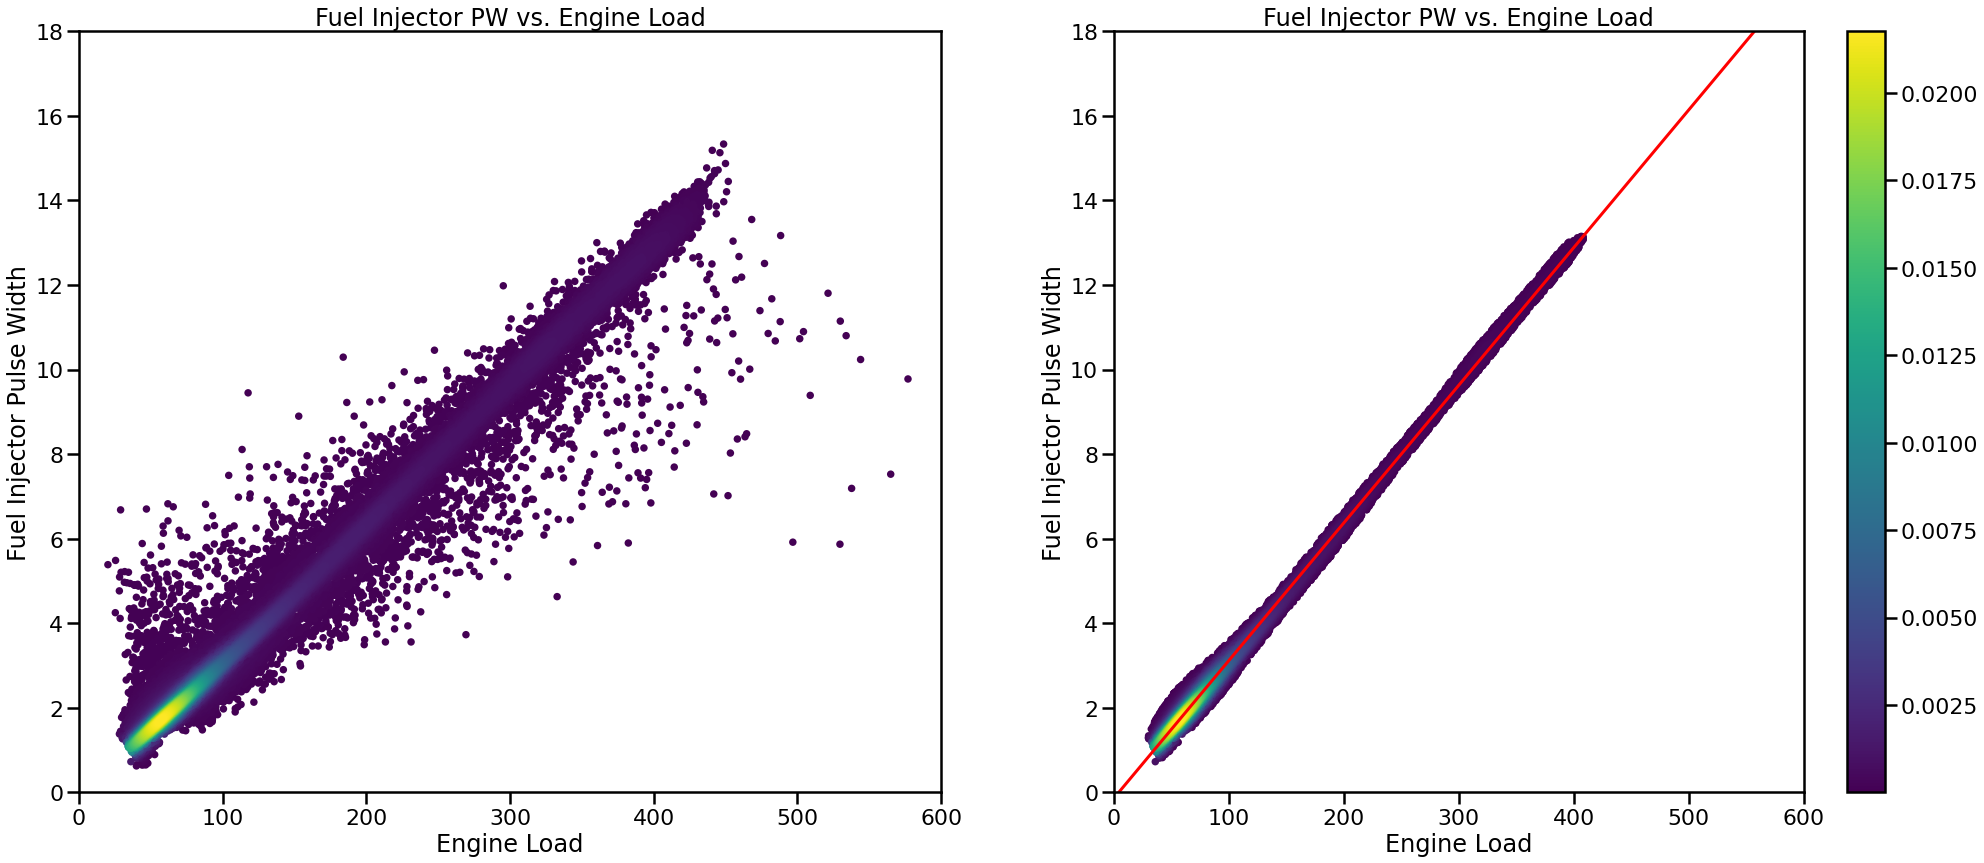

In [64]:
slope, intercept = plot_log(df1)

5030

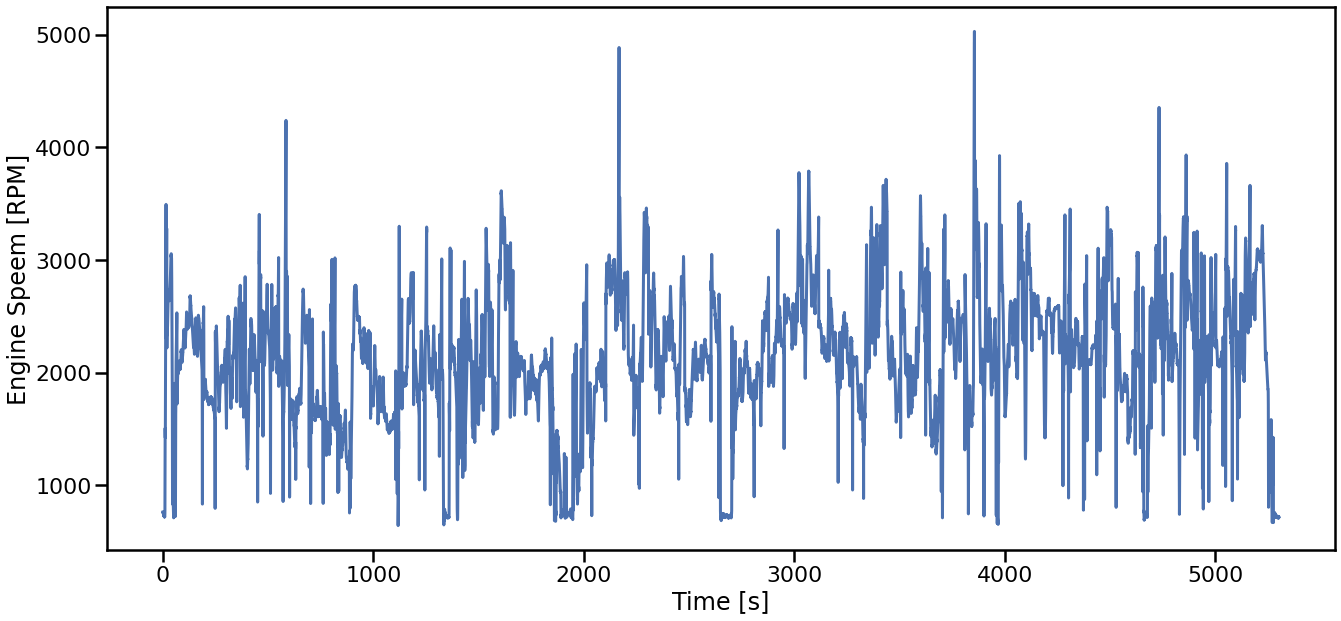

In [65]:
fig, ax = plt.subplots(figsize=(22,10))

ax.plot(df1['Time (msec)']/1000, df1['* Engine Speed (RPM)'])
ax.set_xlabel("Time [s]")
ax.set_ylabel("Engine Speem [RPM]")
#ax.set_xlim(0, 280)
df1['* Engine Speed (RPM)'].max()

In [66]:
high_ipw = df1.sort_values('* Fuel Injector Pulse Width (ms)', ascending=False)
high_ipw = high_ipw[high_ipw['* Fuel Injector Pulse Width (ms)'] < 30]
display(Markdown("## High IPW"))
display(high_ipw)

## High IPW

,Time (msec),* Battery voltage (V),* Coolant Temperature (°C),* Electric fan (%),* Engine Load (mg/stroke),* Engine Speed (RPM),* Fuel Injector Pulse Width (ms),* Ignition Angle (° CRK),* Intake Air Temperature (°C),* Lambda Integrator - Bank 1 (%),* Lambda Integrator - Bank 2 (%),* Mass Airflow (kg/h),* Oil Temperature (°C),* Radiator outlet temperature (°C),* Vehicle Speed (km/h),** Lambda Additive Adaptation - Bank 1 (ms),** Lambda Additive Adaptation - Bank 2 (ms),** Lambda Multiplicative Adaptation - Bank 1 (%),** Lambda Multiplicative Adaptation - Bank 2 (%)
12817,2166966,13.3,96.8,0,448.61,4541,15.332,21.00,40.5,8.48,5.62,366.75,111.2,95.2,61,0.03,0.06,1.97,2.08
12821,2167605,13.4,96.8,0,440.73,4887,15.184,21.38,39.0,6.59,5.74,387.75,111.2,95.2,61,0.03,0.06,1.97,2.08
12816,2166806,13.3,96.8,0,446.05,4452,15.128,21.00,40.5,7.92,7.07,357.50,111.2,95.2,61,0.03,0.06,1.97,2.08
12820,2167445,13.4,96.8,0,449.93,4784,14.872,21.38,39.0,4.86,4.59,387.50,111.2,95.2,61,0.03,0.06,1.97,2.08
2761,466448,13.6,99.0,0,436.83,2114,14.768,16.12,36.0,6.48,7.88,166.25,107.2,89.2,62,0.14,0.11,1.24,1.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28622,4854024,13.2,93.0,0,45.18,1291,0.656,-9.38,41.2,0.00,0.00,10.50,96.1,57.8,57,0.03,0.06,2.45,2.42
22582,3810209,13.5,97.5,0,40.32,1377,0.652,-8.25,33.8,0.00,0.00,10.00,106.4,56.2,70,0.03,0.06,2.23,2.37
267,45240,13.0,102.0,0,46.55,1342,0.648,-8.62,46.5,0.00,0.00,11.25,107.2,65.2,46,0.14,0.11,1.29,1.60
7204,1218143,13.6,97.5,0,44.10,1448,0.644,-7.12,43.5,0.00,0.00,11.50,107.2,70.5,61,0.00,0.00,0.40,0.22


In [67]:
display(Markdown("## Last Entry"))

df = df1
last = df[df['Time (msec)'] == df['Time (msec)'].max()]
display(last)

## Last Entry

,Time (msec),* Battery voltage (V),* Coolant Temperature (°C),* Electric fan (%),* Engine Load (mg/stroke),* Engine Speed (RPM),* Fuel Injector Pulse Width (ms),* Ignition Angle (° CRK),* Intake Air Temperature (°C),* Lambda Integrator - Bank 1 (%),* Lambda Integrator - Bank 2 (%),* Mass Airflow (kg/h),* Oil Temperature (°C),* Radiator outlet temperature (°C),* Vehicle Speed (km/h),** Lambda Additive Adaptation - Bank 1 (ms),** Lambda Additive Adaptation - Bank 2 (ms),** Lambda Multiplicative Adaptation - Bank 1 (%),** Lambda Multiplicative Adaptation - Bank 2 (%)
31199,5302674,13.5,102.8,0,79.06,720,2.712,4.88,47.2,14.56,13.55,10.25,104.1,63.8,0,0.03,0.06,2.58,2.39


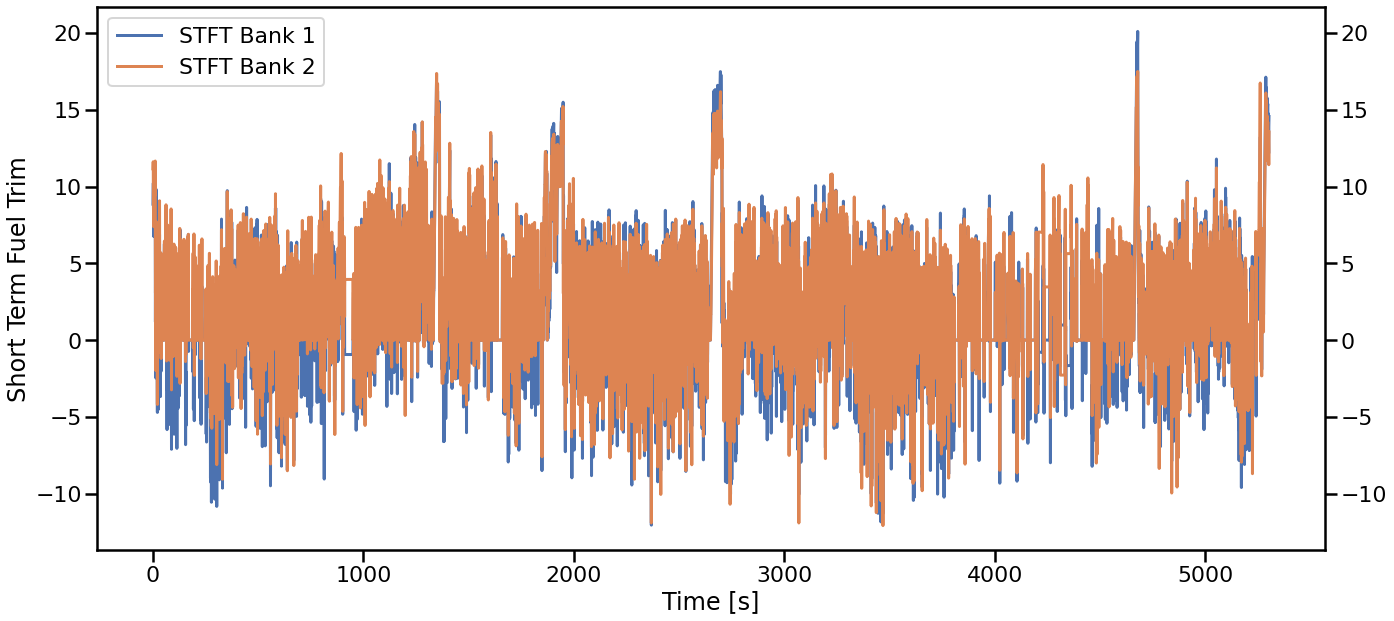

In [68]:
fig, ax = plt.subplots(figsize=(22,10))

df = df1

ax.plot(df['Time (msec)']/1000, df['* Lambda Integrator - Bank 1 (%)'], label="STFT Bank 1")
ax.plot(df['Time (msec)']/1000, df['* Lambda Integrator - Bank 2 (%)'], label="STFT Bank 2")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Short Term Fuel Trim")
#ax.set_xlim(0, 280)
ax.tick_params(left=True, right=True, labelleft=True, labelright=True)
ax.legend()

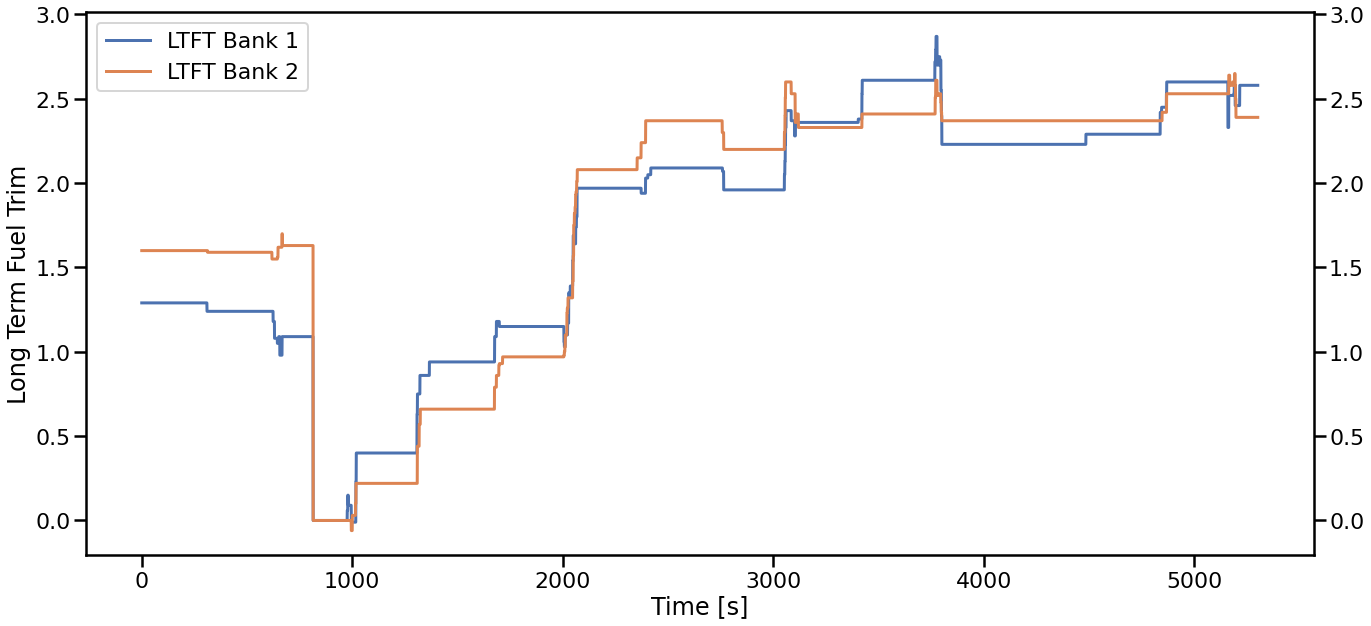

In [69]:
fig, ax = plt.subplots(figsize=(22,10))

df = df1
ax.plot(df['Time (msec)']/1000, df['** Lambda Multiplicative Adaptation - Bank 1 (%)'], label="LTFT Bank 1")
ax.plot(df['Time (msec)']/1000, df['** Lambda Multiplicative Adaptation - Bank 2 (%)'], label="LTFT Bank 2")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Long Term Fuel Trim")
ax.tick_params(left=True, right=True, labelleft=True, labelright=True)
#ax.set_xlim(0, 280)
ax.legend()

In [74]:
from io import StringIO
import pyperclip

def read_map(s):
    rows = s.split('\n')
    m = [r.split('\t') for r in rows]
    df = pd.DataFrame(m)
    
    # Get the table headers and indices
    y_axis = df.loc[:,0][2:].astype(float).round(1).values
    x_axis = df.loc[1][:-1].astype(float).round(0) # The values have useless decimals
    
    # and remove them from the values themselves
    df = df.loc[2:]
    df = df.loc[:,1:]
    
    # Set the headers and indices
    df.columns = x_axis
    df = df.set_index(y_axis)
        
    df = df.astype(float).round(4)  # round the table so it's less stupid with the precision
    return df


def apply_linear(fuel_map, slope, intercept):   
    print(f'Applying function {slope} x + {intercept}')
    new_map = fuel_map.copy()
    for i in range(len(fuel_map.columns)):
        new_map.iloc[:,i] = (fuel_map.columns * slope + intercept)[i].round(3)

    return new_map
    

# Read the fuel map from RomRaider
fuel_map = read_map('''
[Table3D]
33.000274017	49.998488379	70.00636164299999	99.996976758	130.008786654	199.993953516	249.99244189499998	299.990930274	349.989418653	419.99578029599996	500.006078571	600.003055329
400.0	0.844	1.208	1.62	2.3040000000000003	3.024	4.9	6.264	7.664000000000001	9.096	11.36	13.524000000000001	16.232
650.0	0.78	1.12	1.5	2.132	2.8000000000000003	4.5360000000000005	5.8	7.096	8.424	10.52	12.524000000000001	15.028
900.0	0.78	1.096	1.532	2.12	2.856	4.556	5.84	7.2	8.44	10.46	12.452	14.944
1250.0	0.78	1.084	1.528	2.204	2.88	4.596	5.82	7.2	8.52	10.432	12.424	14.904
1500.0	0.78	1.1360000000000001	1.54	2.204	2.896	4.556	5.832	7.112	8.46	10.428	12.416	14.896
1750.0	0.78	1.1440000000000001	1.528	2.204	2.924	4.572	5.828	7.152	8.512	10.42	12.408	14.888
2000.0	0.78	1.16	1.536	2.216	2.916	4.54	5.792	7.0200000000000005	8.272	10.208	12.272	14.584
3000.0	0.78	1.164	1.572	2.2760000000000002	2.932	4.5360000000000005	5.708	6.936	8.22	10.028	12.040000000000001	14.332
3750.0	0.78	1.108	1.552	2.12	2.852	4.432	5.676	6.876	8.096	9.852	12.068	14.484
4000.0	0.78	1.1	1.532	2.2	2.848	4.408	5.656	6.912	8.124	9.864	12.176	14.612
4250.0	0.78	1.096	1.536	2.192	2.828	4.392	5.676	6.884	8.108	9.8	12.056000000000001	14.468
4500.0	0.78	1.1	1.54	2.196	2.844	4.424	5.596	6.876	8.028	9.792	12.06	14.472
5000.0	0.78	1.096	1.536	2.192	2.84	4.42	5.636	6.852	8.040000000000001	9.816	11.996	14.42
5500.0	0.78	1.1	1.54	2.196	2.84	4.42	5.632	6.84	8.048	9.804	11.992	14.44
6000.0	0.78	1.12	1.568	2.24	2.876	4.468	5.644	6.772	8.016	9.784	12.004	14.456
6500.0	0.78	1.088	1.524	2.176	2.84	4.5600000000000005	5.648	6.832	8.184000000000001	9.968	12.144	14.576
'''[1:-1])

# Apply the Affine Function to it
new_fuel_map = apply_linear(fuel_map, slope, intercept)

# Add a bit of IPW (+0.02) to sub-idle (< 720) to help if we drop below
rows = new_fuel_map.index[new_fuel_map.index < 720]
new_fuel_map.loc[rows] += 0.02

# Tinker a bit with the representation of the DataFrame so we can copy it to RomRaider
# The first row needs to be moved one cell to the left
# And [Table3D] added as the first row
csv = new_fuel_map.to_csv(sep='\t')[1:]
csv = '[Table3D]\n' + csv

# Copy the table to the clipboard
pyperclip.copy(csv)

# Display the two maps
display(fuel_map)
display(new_fuel_map)

Applying function 0.0325611168538154 x + -0.14561668444972975


1,33.0,50.0,70.0,100.0,130.0,200.0,250.0,300.0,350.0,420.0,500.0,600.0
400.0,0.844,1.208,1.620,2.304,3.024,4.900,6.264,7.664,9.096,11.360,13.524,16.232
650.0,0.780,1.120,1.500,2.132,2.800,4.536,5.800,7.096,8.424,10.520,12.524,15.028
900.0,0.780,1.096,1.532,2.120,2.856,4.556,5.840,7.200,8.440,10.460,12.452,14.944
1250.0,0.780,1.084,1.528,2.204,2.880,4.596,5.820,7.200,8.520,10.432,12.424,14.904
1500.0,0.780,1.136,1.540,2.204,2.896,4.556,5.832,7.112,8.460,10.428,12.416,14.896
1750.0,0.780,1.144,1.528,2.204,2.924,4.572,5.828,7.152,8.512,10.420,12.408,14.888
2000.0,0.780,1.160,1.536,2.216,2.916,4.540,5.792,7.020,8.272,10.208,12.272,14.584
3000.0,0.780,1.164,1.572,2.276,2.932,4.536,5.708,6.936,8.220,10.028,12.040,14.332
3750.0,0.780,1.108,1.552,2.120,2.852,4.432,5.676,6.876,8.096,9.852,12.068,14.484
4000.0,0.780,1.100,1.532,2.200,2.848,4.408,5.656,6.912,8.124,9.864,12.176,14.612


1,33.0,50.0,70.0,100.0,130.0,200.0,250.0,300.0,350.0,420.0,500.0,600.0
400.0,0.949,1.502,2.154,3.13,4.107,6.387,8.015,9.643,11.271,13.55,16.155,19.411
650.0,0.949,1.502,2.154,3.13,4.107,6.387,8.015,9.643,11.271,13.55,16.155,19.411
900.0,0.929,1.482,2.134,3.11,4.087,6.367,7.995,9.623,11.251,13.53,16.135,19.391
1250.0,0.929,1.482,2.134,3.11,4.087,6.367,7.995,9.623,11.251,13.53,16.135,19.391
1500.0,0.929,1.482,2.134,3.11,4.087,6.367,7.995,9.623,11.251,13.53,16.135,19.391
1750.0,0.929,1.482,2.134,3.11,4.087,6.367,7.995,9.623,11.251,13.53,16.135,19.391
2000.0,0.929,1.482,2.134,3.11,4.087,6.367,7.995,9.623,11.251,13.53,16.135,19.391
3000.0,0.929,1.482,2.134,3.11,4.087,6.367,7.995,9.623,11.251,13.53,16.135,19.391
3750.0,0.929,1.482,2.134,3.11,4.087,6.367,7.995,9.623,11.251,13.53,16.135,19.391
4000.0,0.929,1.482,2.134,3.11,4.087,6.367,7.995,9.623,11.251,13.53,16.135,19.391
